In [1]:
import numpy as np
import scipy.io
import skimage.feature
import matplotlib
import matplotlib.pyplot as plt
import time
from matplotlib.patches import Ellipse
%matplotlib inline 

data = scipy.io.loadmat('data/kfdata.mat')


ImportError: No module named skimage.feature

In [59]:
kfdata = scipy.io.loadmat('data/kfdata.mat')
kfdata_observed = kfdata['data']
kfdata_true = kfdata['true_data']

# our dynamics are described by random accelerations
A = np.asarray([
    [ 1, 0, 1, 0, 0.5, 0 ],
    [ 0, 1, 0, 1, 0, 0.5 ],
    [ 0, 0, 1, 0, 1, 0 ],
    [ 0, 0, 0, 1, 0, 1 ],
    [ 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 1 ] ])
 
# our observations are only the position components
C = np.asarray([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0]])
 
# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty
Q = 1e-2 * np.eye( 6 )
Q[4,4] = 0.5  # variance of accelerations is higher
Q[5,5] = 0.5
 
# our observation noise
R = 20 * np.eye( 2 )
 
# initial state
mu_t = np.zeros(( 6, 1 ))
sigma_t = np.eye( 6 )

In [61]:
def calcMu(A, C, mu, Q, R, sigma, y):
    yHat_t = C.dot(A).dot(mu)
    sigmaPrime_t = A.dot(sigma).dot(A.T) + Q
    s_t = C.dot(sigma).dot(C.T) + R
    k_t = sigmaPrime_t.dot(C.T).dot(np.linalg.pinv(s_t))
    newMu = A.dot(mu) + k_t.dot(y - yHat_t)
    newSigma =(np.eye(6) - k_t.dot(C)).dot(sigmaPrime_t)
    return newMu, newSigma
    

In [62]:
mus = np.zeros(( 1, 2 ))
covs = [[float(sigma_t[0,0]), float(sigma_t[3,3])]]
for y in kfdata_observed:
    mu_t, sigma_t = calcMu(A, C, mu_t, Q, R, sigma_t, np.atleast_2d(y).T)
    nextPostion = mu_t.T[:,:2]
    mus = np.append(mus, nextPostion, axis=0)
    covs.append([float(sigma_t[0,0]), float(sigma_t[3,3])])



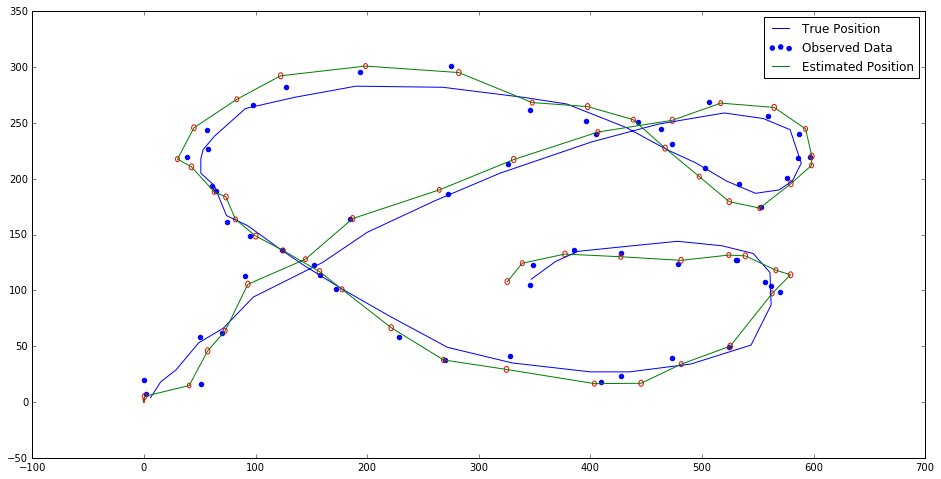

In [63]:
def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )

matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)

fig = plt.figure(0)
ax = fig.add_subplot(111, aspect='equal')
mus = np.array( mus )
c1, = ax.plot(kfdata_true[:, 0], kfdata_true[:, 1], color="blue", label="True Position")
c2 = ax.scatter(kfdata_observed[:, 0], kfdata_observed[:, 1], color="blue", label="Observed Data")
c3, = ax.plot(mus[:,0], mus[:,1], color="green", label="Estimated Position")
ax.legend(handles=[c1, c2, c3], loc=0)


##print test
for x in xrange(len(cov_a)):
    ells = Ellipse(xy=np.array( [ mus[x][0], mus[x][1] ] ) , height=covs[x][0], width=covs[x][1], fill=False, color='red')
    ax.add_artist(ells)
    
plt.show()
    


In [64]:
tmp = scipy.io.loadmat('ball_data.mat')
frames = tmp['frames']  # frames of our video
ball = tmp['ball']  # our little template

# our dynamics are described by random accelerations
A = np.asarray([
    [ 1, 0, 1, 0, 0.5, 0 ],
    [ 0, 1, 0, 1, 0, 0.5 ],
    [ 0, 0, 1, 0, 1, 0 ],
    [ 0, 0, 0, 1, 0, 1 ],
    [ 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 1 ] ])
 
# our observations are only the position components
C = np.asarray([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0]])
 
# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty
Q = 1e-2 * np.eye( 6 )
Q[4,4] = 0.5  # variance of accelerations is higher
Q[5,5] = 0.5
 
# our observation noise
R = 20 * np.eye( 2 )
 
# initial state
mu_t = np.zeros(( 6, 1 ))
sigma_t = np.eye( 6 )

In [65]:
mus = np.zeros(( 1, 2 ))
mus = np.delete(mus, 0, 0)
covs = []

data = []
for i in range( 0, frames.shape[1] ):
    tmp = np.reshape( frames[:,i], (360,243) ).T  # slurp out a frame
    ncc = skimage.feature.match_template( tmp, ball )  # create a normalized cross correlation image
    maxloc = np.unravel_index( tmp.argmax(), tmp.shape )  # find the point of highest correlation
    data.append( maxloc )  # record the results

data = np.asarray( data )


for y in data:
    mu_t, sigma_t = calcMu(A, C, mu_t, Q, R, sigma_t, np.atleast_2d(y).T)
    nextPostion = mu_t.T[:,:2]
    mus = np.append(mus, nextPostion, axis=0)
    covs.append([float(sigma_t[0,0]), float(sigma_t[3,3])])



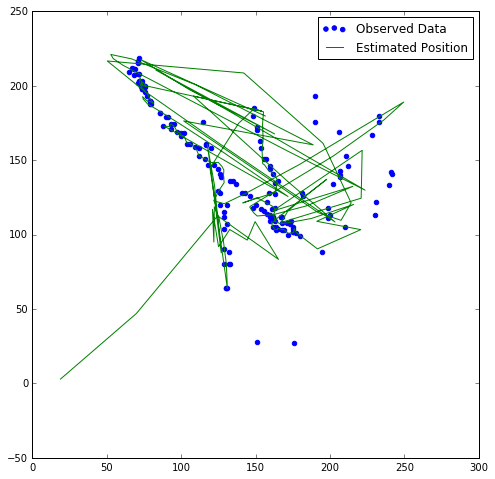

In [66]:
fig = plt.figure(0)
ax = fig.add_subplot(111, aspect='equal')
mus = np.array( mus )
#c1, = ax.plot(kfdata_true[:, 0], kfdata_true[:, 1], color="blue", label="True Position")
c2 = ax.scatter(data[:, 0], data[:, 1], color="blue", label="Observed Data")
c3, = ax.plot(mus[:,0], mus[:,1], color="green", label="Estimated Position")
ax.legend(handles=[c2, c3], loc=0)
    
plt.show()

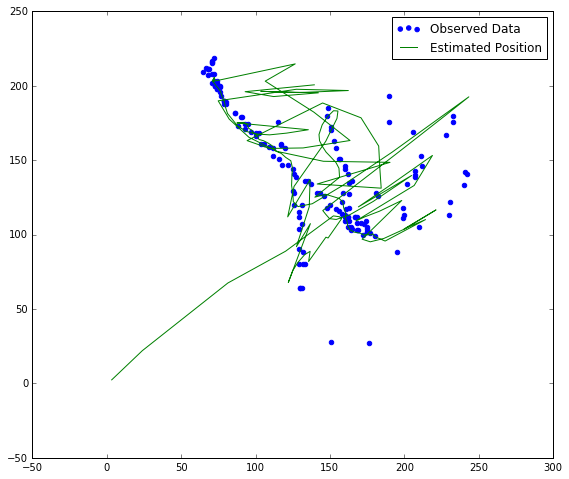

In [89]:
tmp = scipy.io.loadmat('ball_data.mat')
frames = tmp['frames']  # frames of our video
ball = tmp['ball']  # our little template

# our dynamics are described by random accelerations
A = np.asarray([
    [ 1, .1, .1, 1, 0.5, 1 ],
    [ 0, 1, 0, 1, 0, 0.5 ],
    [ 0, 0, 1, 0, 1, 0 ],
    [ 0, 0, 0, 1, .1, 1 ],
    [ 0, 0, 0, 0, 1, .1 ],
    [ 0, 0, 0, 0, 0, 1 ] ])
 
# our observations are only the position components
C = np.asarray([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0]])
 
# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty
Q = 1e-2 * np.eye( 6 )
Q[1,1] = 5
Q[2,2] = .9
Q[3,3] = .5
Q[4,4] = .7  # variance of accelerations is higher
Q[5,5] = .7
Q[0,0] = .3 

# our observation noise
R = 200 * np.eye( 2 )
 
# initial state
mu_t = np.zeros(( 6, 1 ))
sigma_t = np.eye( 6 )

mus = np.zeros(( 1, 2 ))
mus = np.delete(mus, 0, 0)
covs = []

data = []
for i in range( 0, frames.shape[1] ):
    tmp = np.reshape( frames[:,i], (360,243) ).T  # slurp out a frame
    ncc = skimage.feature.match_template( tmp, ball )  # create a normalized cross correlation image
    maxloc = np.unravel_index( tmp.argmax(), tmp.shape )  # find the point of highest correlation
    data.append( maxloc )  # record the results

data = np.asarray( data )


for y in data:
    mu_t, sigma_t = calcMu(A, C, mu_t, Q, R, sigma_t, np.atleast_2d(y).T)
    nextPostion = mu_t.T[:,:2]
    mus = np.append(mus, nextPostion, axis=0)
    covs.append([float(sigma_t[0,0]), float(sigma_t[3,3])])

fig = plt.figure(0)
ax = fig.add_subplot(111, aspect='equal')
mus = np.array( mus )
c2 = ax.scatter(data[:, 0], data[:, 1], color="blue", label="Observed Data")
c3, = ax.plot(mus[:,0], mus[:,1], color="green", label="Estimated Position")
ax.legend(handles=[c2, c3], loc=0)
    
plt.show()

In [ ]:
for t in range(0, data.shape[0]):
 
    tmp = np.reshape( frames[:,t], (360,243) ).T
 
    fig = plt.figure(1)
    ax = fig.add_subplot(111, aspect='equal')
    #fig.clf()
    ax.imshow( tmp, interpolation='nearest', cmap=matplotlib.cm.gray )
    ax.scatter( data[t][1], data[t][0] )
    ax.scatter( mus[t][1], mus[t][0] )
 
    ells = Ellipse(xy=np.array( [ mus[t][1], mus[t][0] ] ) , height=sigmas[t][1], width=sigmas[t][0], fill=False, color='red')
    ax.add_artist(ells)
    ax.plot( sigmas[t][1] + mus[t][1], sigmas[t][0] + mus[t][0] )
    ax.set_xlim([1, 360])
    ax.set_ylim([243,1])
 
    #display.clear_output(wait=True)
    #display.display(plt.gcf())
    #fig.clf()
    #time.sleep(0.3)
    
    if t in [54, 56, 78, 106, 107]:
        #display.clear_output(wait=True)
        plt.title("Frame: %d" % t)
        display.display(plt.gcf())
    fig.clf()